# HbA1c Level and BMI Regression with Keras Normalization

In [1]:
# Import required libraries for regression, preprocessing, and evaluation
import pandas as pd
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from keras.layers import Normalization

In [2]:
model_df = pd.read_csv("not_scaling.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0,80.0,25.19,6.6,140
1,0,0,0,0,0,1,54.0,27.32,6.6,80
2,0,0,0,0,1,0,28.0,27.32,5.7,158
3,0,0,0,0,0,2,36.0,23.45,5.0,155
4,1,1,0,0,1,2,76.0,20.14,4.8,155


In [3]:
# Define target column and separate continuous and categorical features
target_cols     = ['HbA1c_level', 'bmi']
continuous_cols = [ 'age', 'blood_glucose_level']
categorical_cols     = ['hypertension', 'heart_disease', 'diabetes', 'gender', 'problematic','smoking_history']

In [4]:
X = model_df[continuous_cols +  categorical_cols]
y = model_df[target_cols]

In [5]:
# Split dataset into train and test sets (90% training, 10% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=None 
)

In [6]:
# Since Keras Normalization will be applied, explicit scaling is not performed. 
# Binary and categorical variables are one-hot encoded and will be normalized by Kerass
X_train_num = X_train[continuous_cols]
X_test_num = X_test[continuous_cols]

ohe = OneHotEncoder(sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat  = ohe.transform(X_test[categorical_cols])

cat_cols = ohe.get_feature_names_out(categorical_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=cat_cols)
X_test_cat_df  = pd.DataFrame(X_test_cat,  index=X_test.index,  columns=cat_cols)


X_train_final_df = pd.concat([X_train_num, X_train_cat_df], axis=1)
X_test_final_df  = pd.concat([X_test_num,  X_test_cat_df],  axis=1)

X_train_final = X_train_final_df.values
X_test_final  = X_test_final_df.values

In [7]:
# Normalization layer is used to standardize input features instead of manual scaling.
normalizer = Normalization()
normalizer.adapt(X_train_final)

# Build and train a neural network regression model with Keras Sequential
model = Sequential([
    normalizer,  
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'), 
    Dense(2)  
])


model.compile(optimizer="Adam", loss='mse', metrics=['mae'])
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,
    verbose=1
)

history = model.fit(
    X_train_final, 
    y_train,
    epochs=200,  
    batch_size=128,
    verbose=1,
    validation_split=0.2,
    callbacks=early_stopping
)

2025-08-26 16:35:04.385015: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-26 16:35:04.385041: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-26 16:35:04.385049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-26 16:35:04.385067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-26 16:35:04.385078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (89983, 15)            │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (128.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31 (128.00 B)

Epoch 1/200


2025-08-26 16:35:04.761724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 155.5320 - mae: 6.9406 - val_loss: 93.7822 - val_mae: 4.1922
Epoch 2/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 90.0683 - mae: 4.1498 - val_loss: 70.8715 - val_mae: 3.7520
Epoch 3/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 62.6318 - mae: 3.5873 - val_loss: 43.2482 - val_mae: 3.1562
Epoch 4/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 39.4806 - mae: 3.0770 - val_loss: 30.0293 - val_mae: 2.8290
Epoch 5/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 28.1593 - mae: 2.7908 - val_loss: 21.6580 - val_mae: 2.5724
Epoch 6/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 20.3234 - mae: 2.5761 - val_loss: 17.2492 - val_mae: 2.4738
Epoch 7/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 17.4896 - mae: 2.4761 - val_loss: 16.6992 - val_mae: 2.4352
Epoch 8/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 17.1646 - mae: 2.4673 - val_loss: 16.7170 - val_mae: 2.4538
Epoch 9/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


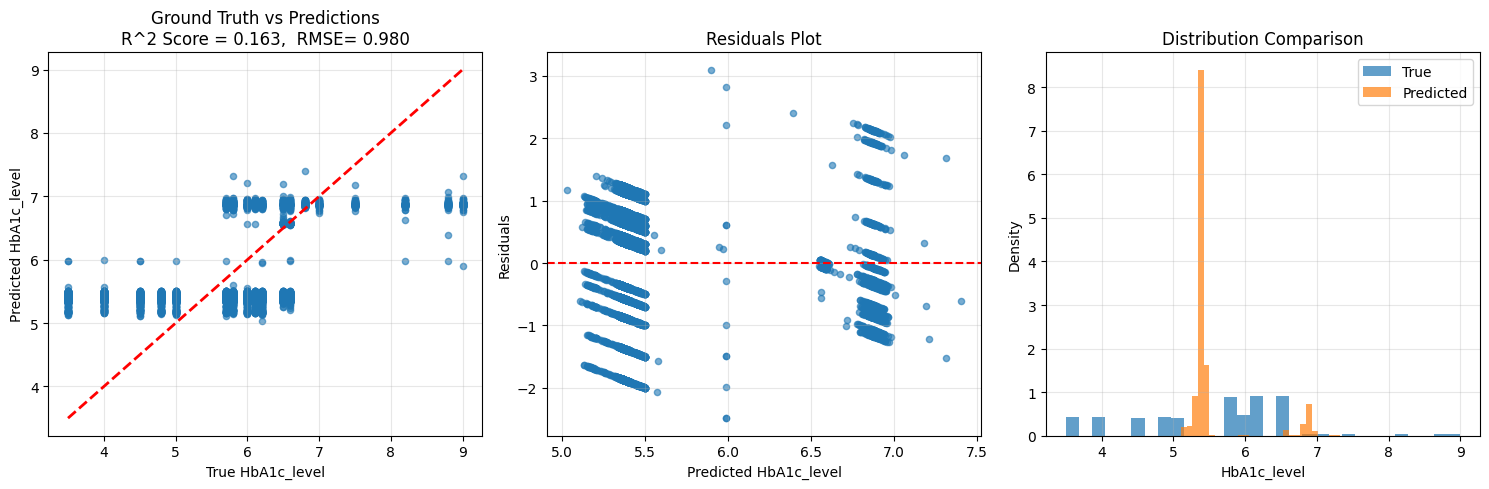

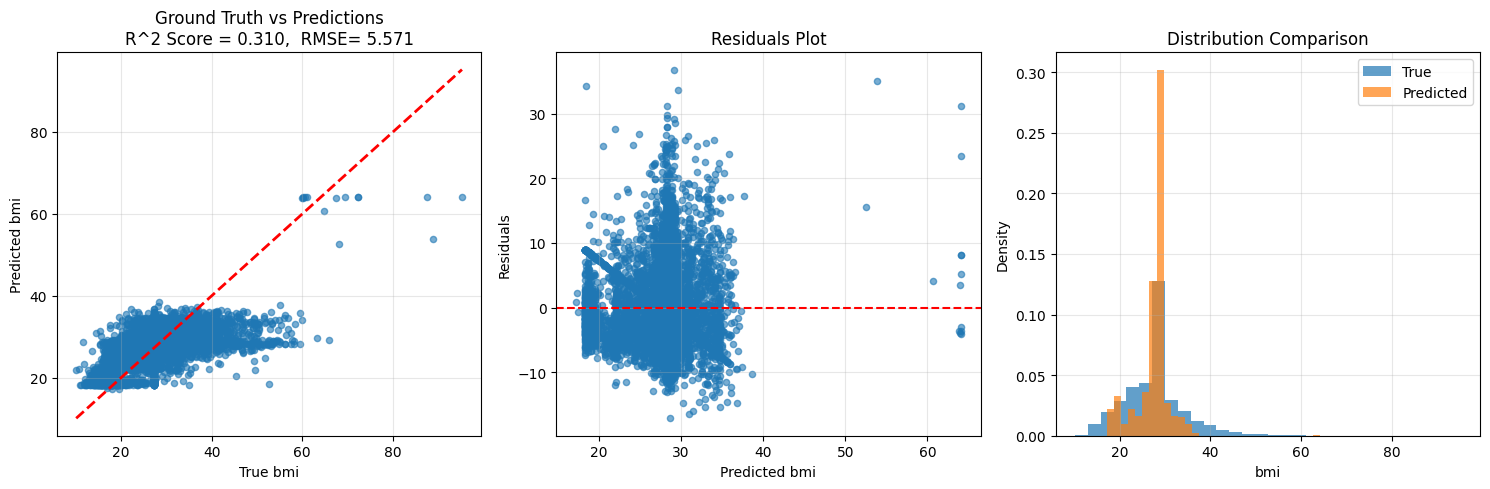

In [8]:
y_pred = model.predict(X_test_final)
y_test_array = y_test.values

# Visualization: Ground truth vs Predictions, Residuals, and Distribution Comparison
for i, name in enumerate(target_cols):
    r2 = r2_score(y_test_array[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test_array[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    
    plt.figure(figsize=(15, 5))

    # 1. Ground Truth 
    plt.subplot(1, 3, 1)
    plt.scatter(y_test_array[:, i], y_pred[:, i], alpha=0.6, s=20)
    plt.plot([y_test_array[:, i].min(), y_test_array[:, i].max()], 
             [y_test_array[:, i].min(), y_test_array[:, i].max()], 'r--', lw=2)
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'Ground Truth vs Predictions\nR^2 Score = {r2:.3f},  RMSE= {rmse:.3f}')
    plt.grid(True, alpha=0.3)

    # 2. Residuals Plot
    plt.subplot(1, 3, 2)
    residuals = y_test_array[:, i] - y_pred[:, i]  
    plt.scatter(y_pred[:, i], residuals, alpha=0.6, s=20)  
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicted {name}')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.grid(True, alpha=0.3)

    # 3. Distribution Comparison
    plt.subplot(1, 3, 3)
    plt.hist(y_test_array[:, i], bins=30, alpha=0.7, label='True', density=True)
    plt.hist(y_pred[:, i], bins=30, alpha=0.7, label='Predicted', density=True)
    plt.xlabel(f'{name}')
    plt.ylabel('Density')
    plt.title('Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()